# Point-by-point refined map visualisation notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will convert the (potentially) multi-valued results of a point-by-point strain refinement process to a single-valued 'TensorMap' with many useful export formats, like H5, Paraview XDMF, and MTEX CTF.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# the minimum number of peaks you want a pixel to have to be counted
min_unique = 400

dset_prefix = "top_"  # some common string in the names of the datasets if processing multiple scans

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [4]:
# Parameters
phase_str = "Fe"
min_unique = 250
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"


In [5]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from ImageD11.grain import grain
from ImageD11 import unitcell
import ImageD11.sinograms.dataset
from ImageD11.sinograms.point_by_point import PBPMap, PBPRefine
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.nbGui import nb_utils as utils

%matplotlib ipympl

# Load data
## Dataset

In [6]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [8]:
ref_ucell = ds.phases.unitcells[phase_str]
print(ref_ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


# Point-by-point refined map

Loading peaks


Loading input map
Loading output map


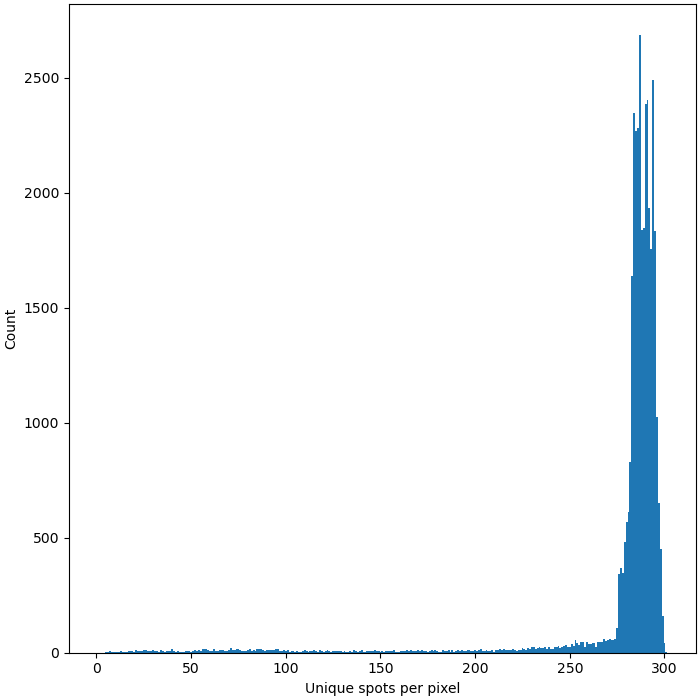

In [9]:
refmanpath = os.path.splitext(ds.refmanfile)[0] + f'_{phase_str}.h5'
refine = PBPRefine.from_h5(refmanpath)
refine.refinedmap.plot_nuniq_hist()

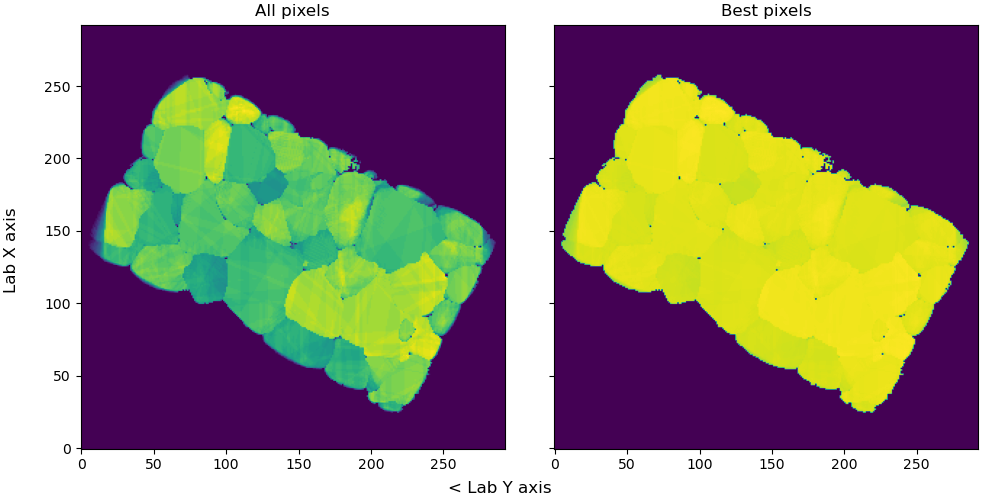

In [10]:
# choose the minimum number of peaks you want a pixel to have to be counted
refine.refinedmap.choose_best(min_unique)
refine.refinedmap.plot_best(min_unique)

# Make TensorMap

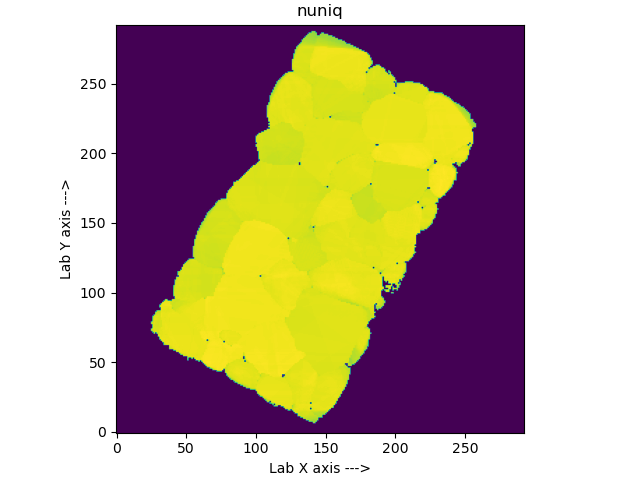

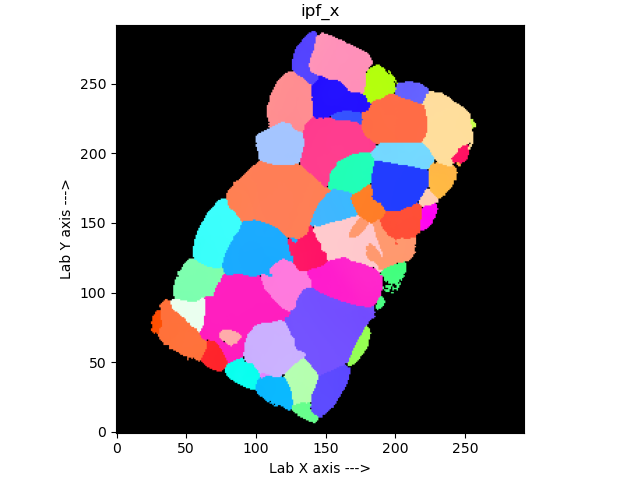

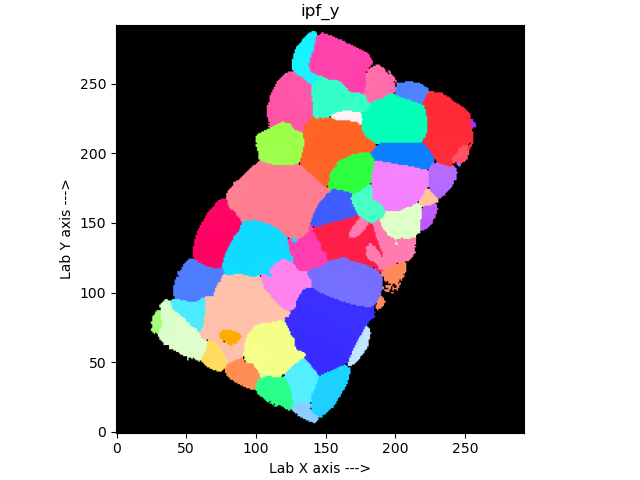

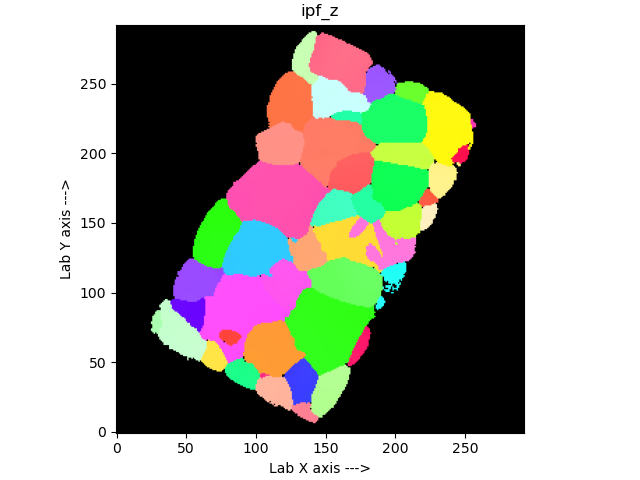

In [11]:
# now make a TensorMap from our refined map so we can plot and export
# let's make a phase id map from our pbpmap
phase_ids = TensorMap.recon_order_to_map_order(np.where(refine.refinedmap.best_nuniq > min_unique, 0, -1))
eps_sample = TensorMap.recon_order_to_map_order(refine.refinedmap.best_eps)
tmap = TensorMap.from_pbpmap(refine.refinedmap, steps=(1, ds.ystep, ds.ystep), phases={0: ref_ucell})
tmap['phase_ids'] = phase_ids
tmap['eps_sample'] = eps_sample
tmap.get_ipf_maps()
tmap.plot('nuniq')
tmap.plot('ipf_x')
tmap.plot('ipf_y')
tmap.plot('ipf_z')
eul = tmap.euler  # trigger calculation of all the maps

/tmp/ipykernel_2067495/331490407.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu_r')


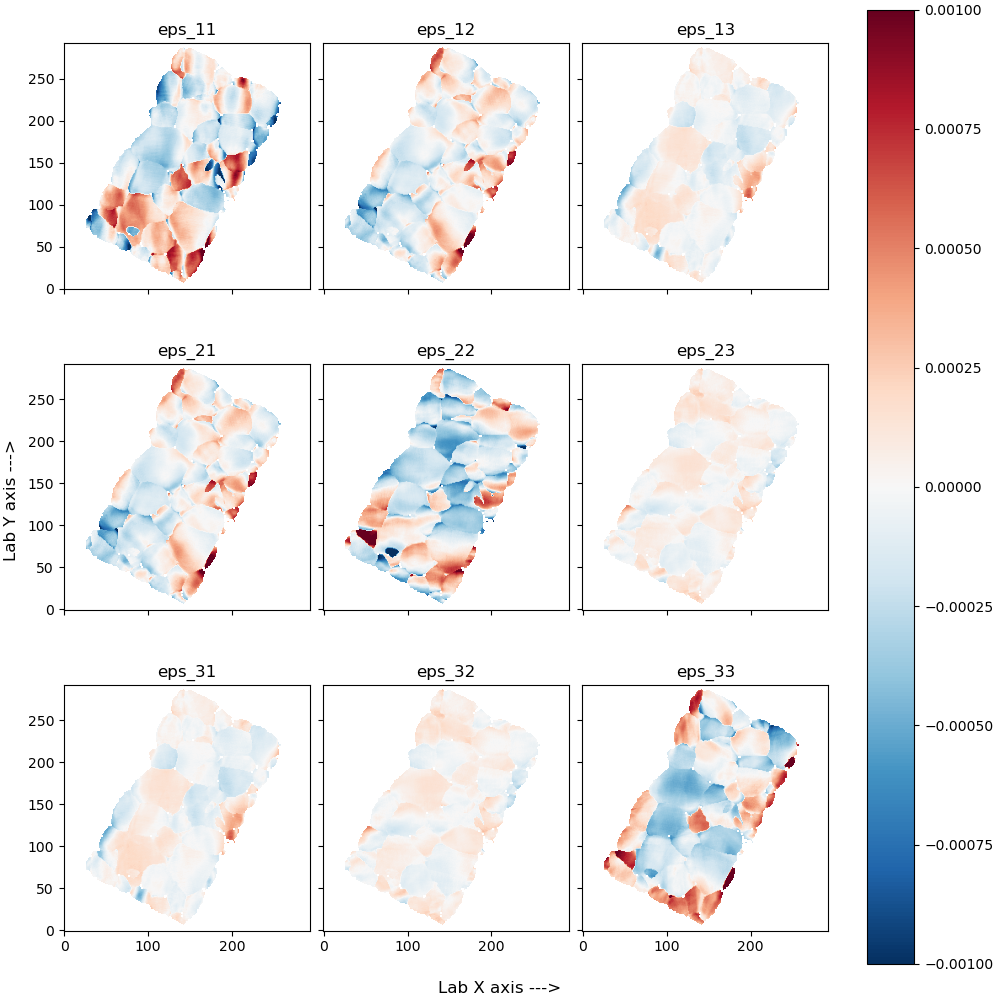

In [12]:
# plot some (hopefully cleaner) strains

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, layout='constrained', figsize=(10,10))
cmap = cm.get_cmap('RdBu_r')
normalizer = Normalize(-1e-3, 1e-3)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(tmap.eps_sample[0, ..., i, j], origin="lower", cmap=cmap, norm=normalizer)
        axs[i,j].set_title(f'eps_{i+1}{j+1}')
fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [13]:
# mean unitcell?
print(np.nanmean(tmap.unitcell[0, ...]))

46.43534325752898


In [14]:
# if we have a previous tomographic TensorMap, we can try to get the labels map too:
try:
    tmap_tomo =  TensorMap.from_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)
    tmap.add_map('labels', tmap_tomo.labels)
except (FileNotFoundError, OSError, KeyError):
    # couldn't find one, continue anyway
    pass

# Export
## TensorMap

In [15]:
# save the refined TensorMap to disk

refined_tmap_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_refined_tmap_{phase_str}.h5')
tmap.to_h5(refined_tmap_path)
tmap.to_paraview(refined_tmap_path)

# MTEX

In [16]:
# you can also do an MTEX export if you like:

refined_ctf_path = os.path.join(ds.analysispath, f'{ds.sample}_{ds.dset}_refined_tmap_{phase_str}.ctf')
tmap.to_ctf_mtex(refined_ctf_path, z_index=0)

CTF exported!
In MTEX, run the command:
import_wizard('EBSD')
Click the '+', choose file /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_refined_tmap_Fe.ctf and click 'Open'
Click 'Next >>'
Click 'Next >>' though the phases, changing if necessary (should be right though)
Choose 'apply rotation to Euler angles and spatial coordinates' with an angle of [0,0,0]
Choose the default MTEX plotting convention (X east, Y north)
Click 'Next >>' then 'script (m-file)' for the 'Import to', then 'Finish'
Click 'Run' at the top, save the import script somewhere, then it should run
Your EBSD should now be imported into MTEX. You can try to plot it with 'plot(ebsd)'


In [17]:
ds.save()